In [8]:
# Importing necessary libraries

import numpy as np
from astropy.io import fits
from pathlib import Path
from matplotlib.colors import LogNorm
from astropy.nddata import CCDData
from itertools import cycle
from ccdproc import ImageFileCollection
import ccdproc as ccdp
import os
from astropy.stats import mad_std,sigma_clipped_stats, SigmaClip
import ccdproc as ccdp
import matplotlib.pyplot as plt
#from convenience_functions import show_image
from matplotlib.colors import LogNorm
import astropy.units as u
import glob
import photutils as pht
from photutils.background import Background2D, MedianBackground
from photutils.segmentation import detect_threshold, detect_sources
from photutils.utils import circular_footprint
from scipy.stats import median_abs_deviation as mad

In [4]:
## STEP 0. Specifiying Locations

# Where all your raw frames are located:
path = (r'C:\Users\sarin\OneDrive\Desktop\Rezaei_Dec01_2024\Darks\dark_5min_-25C')

# Create these two folders before running the code
combined_path = Path (r'C:\Users\sarin\OneDrive\Desktop\combined')
#calibrated_path =  (r'C:/Users/sarin/OneDrive/Desktop/combined')

# Choose names for master flat and dark
combined_dark_name = 'master_dark_trimonly.fits'
combined_flat_name = 'master_flat_trimonly.fits'
calibrated_darkandflat = 'calibrated_light_minus_dark_div_flat.fits'
calibrated_flatonly = 'calibrated_light_div_flatonly.fits'
combined_bias_name= 'master_dark_trimonly.fits'

# Put one of your light frame names for plots
light_frame_name = 'c13a_150210_023444_ori_Trim_only_v4.fits'

INFO:astropy:splitting each image into 10 chunks to limit memory usage to 350000000.0 bytes.


INFO: splitting each image into 10 chunks to limit memory usage to 350000000.0 bytes. [ccdproc.combiner]


Text(0.5, 1.0, 'combined dark')

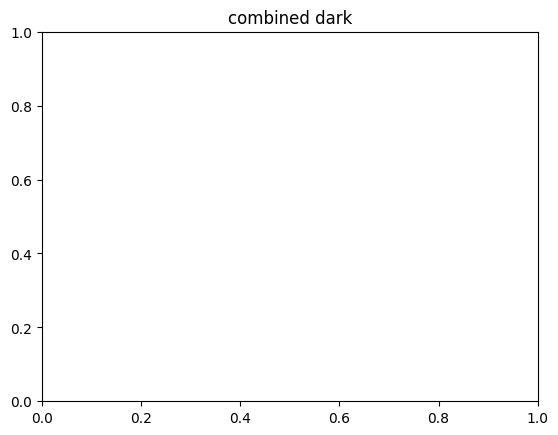

In [7]:
combined_dark_file = combined_path / combined_dark_name

    # Perform the combination if the file doesn't exist
main_path = ccdp.ImageFileCollection(path)  # Assuming 'path' is defined somewhere

    # Performing the actual combination of the bias images and performing sigmaclipping as well.
all_darks = main_path.files_filtered(IMG_TYP='DARK', include_path=True)  # Get all DARK files

combined_dark = ccdp.combine(all_darks,
                              method='median',
                              sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                              sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std,
                              mem_limit=350e6
                                 )

combined_dark.meta['comb-med'] = True

combined_dark.write(combined_path / combined_dark_name, overwrite=True)
    
#plt.imshow(combined_dark, cmap='gray')
#plt.title('combined dark')
#plt.show()

In [23]:
#First, you should make your combined_dark.
# Vewing one flat file
ifc_raw = ccdp.ImageFileCollection(r'C:\Users\sarin\flat')
filtered_files = ifc_raw.files_filtered(IMG_TYP='flat', include_path=True)
if filtered_files:  # Check if the list is not empty
    singl_flat = CCDData.read(filtered_files[0], BUNIT='adu')
    print(singl_flat.shape)

else:
    print("No flatfield images found")


(4096, 4096)


In [24]:
combined_file=Path(
#combined_file = os.path.join(combined_path, combined_dark_name )


In [25]:
combined_dark = CCDData.read(combined_file, BUNIT='adu')

In [55]:
#The grid of my combined_dark and a flat wasn't the same, so I should have Binned the combined_dark to have the same figures for abstracting!
#You may not need this step, so skip.
from astropy.nddata import block_reduce
import numpy as np

# Bin the flat frame by 2x2 (4096→2048)
binned_flat_data = block_reduce(singl_flat.data, block_size=(2, 2), func=np.mean)
binned_flat = CCDData(binned_flat_data, unit=singl_flat.unit, meta=singl_flat.meta)

# Now subtract dark
b_flat_reduced = ccdp.subtract_dark( combined_dark,binned_flat, exposure_time='exptime', exposure_unit=10*u.second, scale=False)

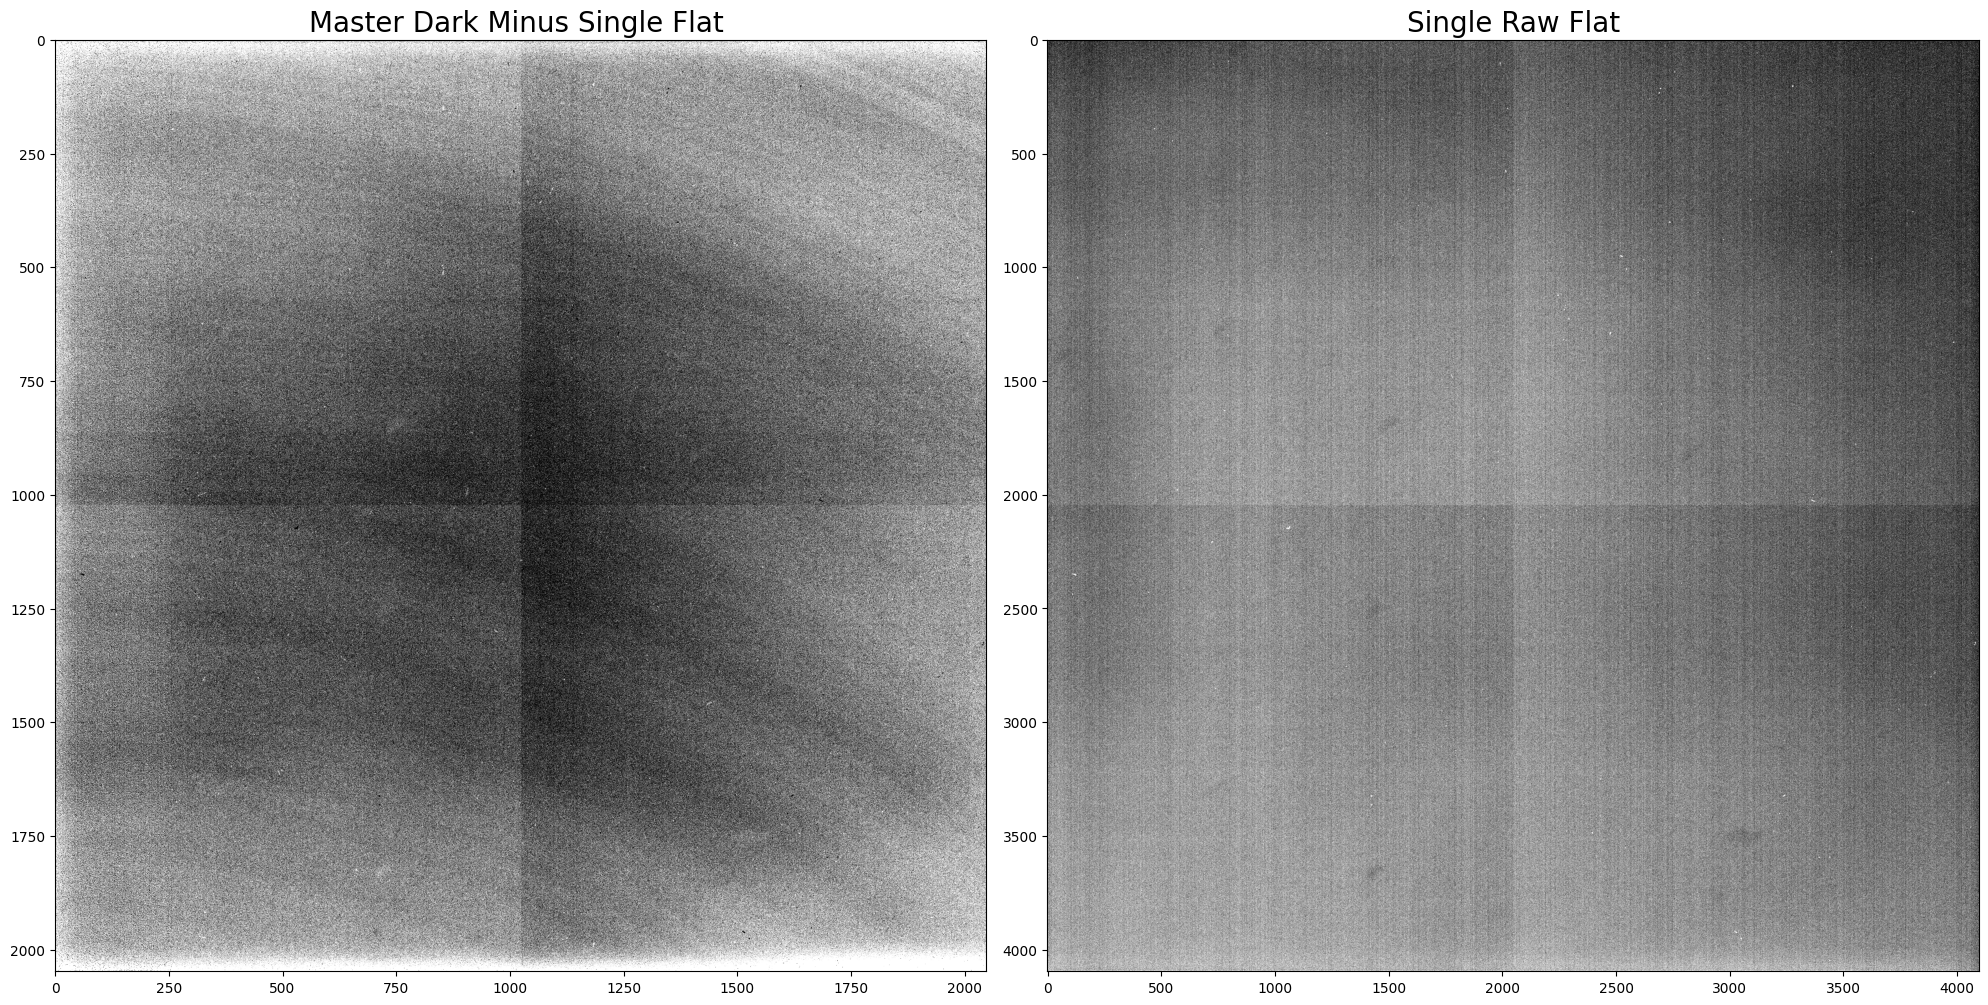

In [57]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))  # 1 row, 2 columns

# Plot dark-subtracted flat on ax1
ax1.imshow(b_flat_reduced, cmap='gray', vmin=np.percentile(b_flat_reduced, 5), vmax=np.percentile(b_flat_reduced, 95))
ax1.set_title('Master Dark Minus Single Flat ', fontsize=20)

# Plot original flat on ax2
ax2.imshow(singl_flat, cmap='gray', vmin=np.percentile(singl_flat, 5), vmax=np.percentile(singl_flat, 95))
ax2.set_title('Single Raw Flat', fontsize=20)

plt.tight_layout()  # Prevent overlapping labels
plt.show()